## Import Necessary Libraries

In [117]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import zipfile
import random
import shutil
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report

print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

Keras version: 3.12.0
Using backend: tensorflow


### Check Device Availability

Let's verify whether GPU acceleration is available for faster training:

In [94]:
# Check for GPU availability
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("  Training will be significantly faster on GPU!")
else:
    device = torch.device("cpu")
    print("⚠ No GPU detected - using CPU")
    print("  Training will be slower. Consider using Google Colab or Kaggle Kernel for free GPU access.")

⚠ No GPU detected - using CPU
  Training will be slower. Consider using Google Colab or Kaggle Kernel for free GPU access.


## Import Data

In [95]:
source_path = 'breast_cancer_data'

for label in ['benign', 'malignant', 'normal']:
    print(f"There are {len(os.listdir(os.path.join(source_path, str(label))))} images of {label} tumor status.")

There are 438 images of benign tumor status.
There are 211 images of malignant tumor status.
There are 134 images of normal tumor status.


## Visual Exploration

Display random sample images from each of the three diagnosis classes to understand data better:

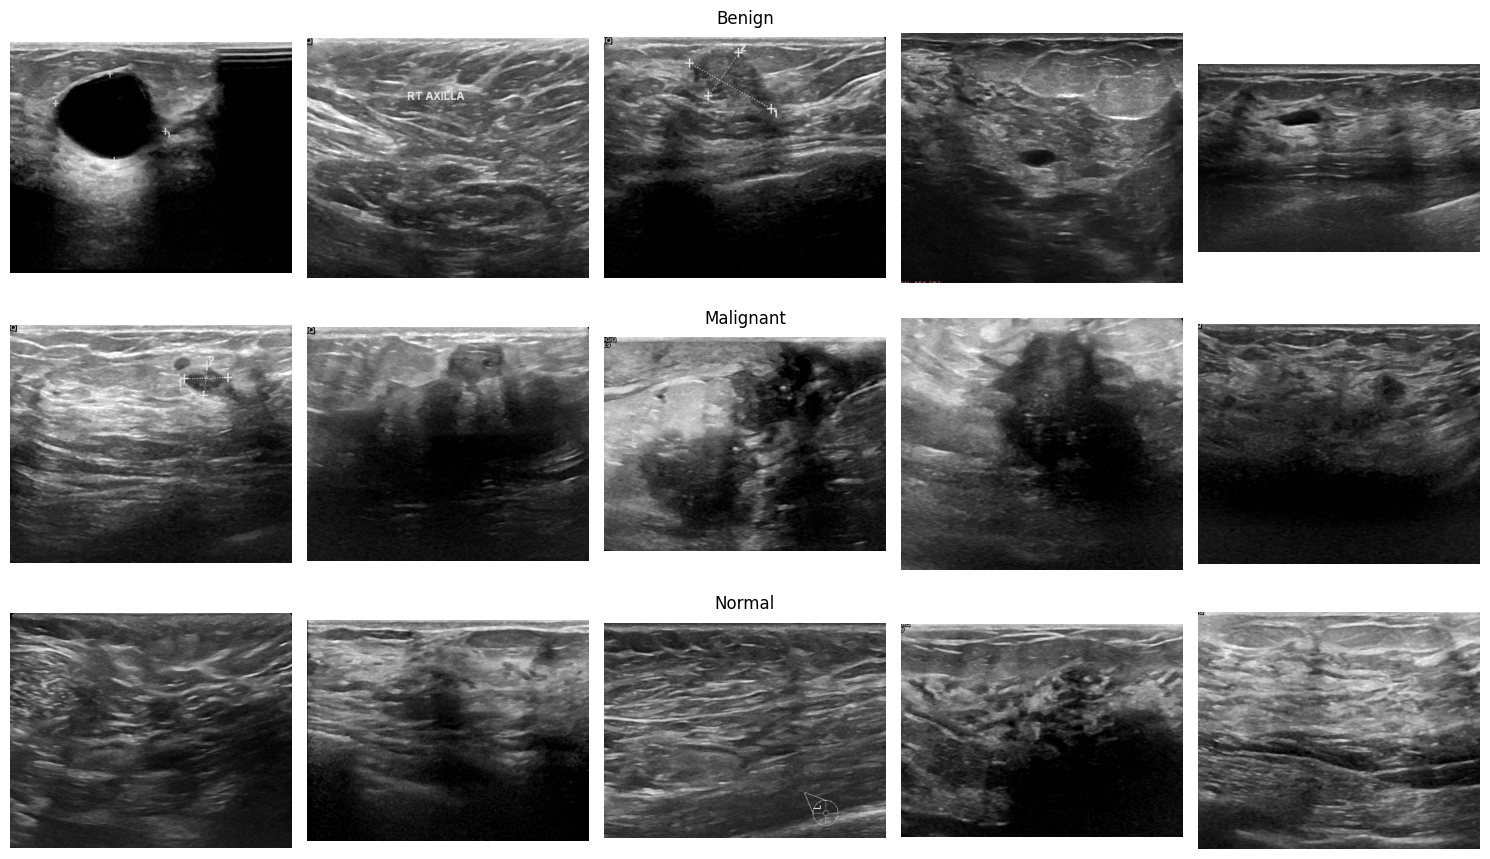

In [96]:
fig = plt.figure(figsize=(15, 9))
for i, class_name in enumerate(['benign', 'malignant', 'normal']):
    class_path = f'breast_cancer_data/{class_name}'
    images = os.listdir(class_path)
    
    for j in range(5):
        img = plt.imread(f'{class_path}/{random.choice(images)}')
        fig.add_subplot(3, 5, i*5+j+1)
        plt.axis('off')
        plt.imshow(img, cmap='gray')
        if j == 2:
            plt.title(class_name.capitalize(), fontsize=12, pad=10)

plt.tight_layout()
plt.show()

In [97]:
# print out the size of each image
img = plt.imread(f'breast_cancer_data/benign/{random.choice(os.listdir("breast_cancer_data/benign"))}')
print(f"Image size: {img.shape}")

Image size: (475, 558, 3)


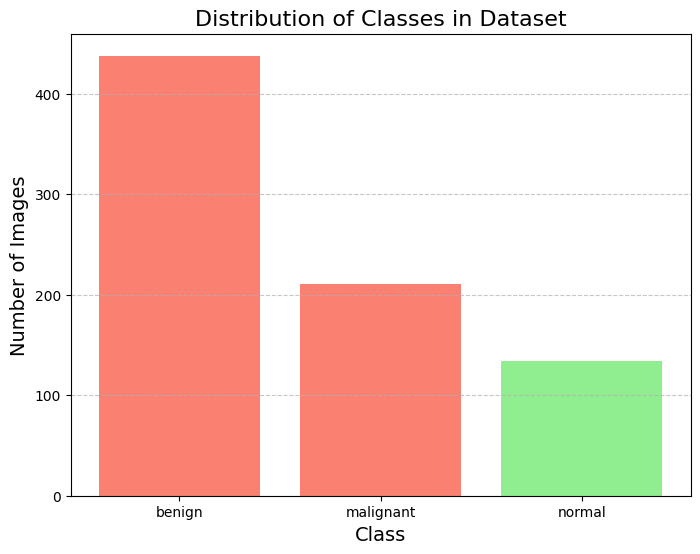

In [98]:
# Define class names
class_names = ['benign', 'malignant', 'normal']
class_counts = []

# Count the number of images in each class
for class_name in class_names:
    class_path = f'breast_cancer_data/{class_name}'
    count = len(os.listdir(class_path))
    class_counts.append(count)

# Plot the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts, color=['salmon', 'salmon', 'lightgreen'])
plt.title('Distribution of Classes in Dataset', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Create New File Storage Directories

In [99]:
#new root directory
root_dir = 'split_data'

#empty directory to prevent future issues
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
  for name in ['benign', 'malignant', 'normal']:
    for name2 in ['training','validation','test']:
      os.makedirs(os.path.join(root_path,name2,str(name)))

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("Error: File already exists.")

In [100]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

split_data/test
split_data/training
split_data/validation
split_data/test/malignant
split_data/test/benign
split_data/test/normal
split_data/training/malignant
split_data/training/benign
split_data/training/normal
split_data/validation/malignant
split_data/validation/benign
split_data/validation/normal


## Split Data into Train, Test, Val datasets

In [101]:
#create directories for split data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, TRAIN_SPLIT, VAL_SPLIT):
    np.random.seed(42)
    files = []
    for name in os.listdir(SOURCE_DIR):
        if os.path.getsize(os.path.join(SOURCE_DIR, name)) > 0:
            files.append(name)
    random.shuffle(files)

    train_size = int(len(files) * TRAIN_SPLIT)
    val_size = int(len(files) * VAL_SPLIT)

    for name in files[:train_size]:
        shutil.copy(os.path.join(SOURCE_DIR, name), os.path.join(TRAINING_DIR, name))
    for name in files[train_size:train_size + val_size]:
        shutil.copy(os.path.join(SOURCE_DIR, name), os.path.join(VALIDATION_DIR, name))
    for name in files[train_size + val_size:]:
        shutil.copy(os.path.join(SOURCE_DIR, name), os.path.join(TEST_DIR, name))

In [102]:
TRAINING_DIR = "split_data/training/"
VALIDATION_DIR = "split_data/validation/"
TEST_DIR = "split_data/test/"

#empty directories to prevent future errors from multiple runs
for i in ['benign', 'malignant', 'normal']:
  label_train_dir = os.path.join(TRAINING_DIR, str(i))
  label_val_dir = os.path.join(VALIDATION_DIR, str(i))
  label_test_dir = os.path.join(TEST_DIR, str(i))
  if len(os.listdir(label_train_dir)) > 0:
    for file in os.scandir(label_train_dir):
      os.remove(file.path)
  if len(os.listdir(label_val_dir)) > 0:
    for file in os.scandir(label_val_dir):
      os.remove(file.path)
  if len(os.listdir(label_test_dir)) > 0:
    for file in os.scandir(label_test_dir):
      os.remove(file.path)

#split proportions
train_split = 0.7
val_split = 0.2
test_split = 0.1

#execute split
for i in ['benign', 'malignant', 'normal']:
  label_train_dir = os.path.join(TRAINING_DIR, str(i))
  label_val_dir = os.path.join(VALIDATION_DIR, str(i))
  label_test_dir = os.path.join(TEST_DIR, str(i))
  split_data(SOURCE_DIR=os.path.join(source_path, str(i)),
             TRAINING_DIR=label_train_dir,
             VALIDATION_DIR=label_val_dir,
             TEST_DIR=label_test_dir,
             TRAIN_SPLIT=train_split,
             VAL_SPLIT=val_split)

#print number of files in each group
for i in ['benign', 'malignant', 'normal']:
  print(f"There are {len(os.listdir(os.path.join(TRAINING_DIR, str(i))))} images of a {i} tumor diagnosis in the training set")
  print(f"There are {len(os.listdir(os.path.join(VALIDATION_DIR, str(i))))} images of a {i} tumor diagnosis in the validation set")
  print(f"There are {len(os.listdir(os.path.join(TEST_DIR, str(i))))} images of a {i} tumor diagnosis in the test set")


There are 306 images of a benign tumor diagnosis in the training set
There are 87 images of a benign tumor diagnosis in the validation set
There are 45 images of a benign tumor diagnosis in the test set
There are 147 images of a malignant tumor diagnosis in the training set
There are 42 images of a malignant tumor diagnosis in the validation set
There are 22 images of a malignant tumor diagnosis in the test set
There are 93 images of a normal tumor diagnosis in the training set
There are 26 images of a normal tumor diagnosis in the validation set
There are 15 images of a normal tumor diagnosis in the test set


## Create Data Generators with Augmentation

In [103]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  #create the ImageDataGenerator class for the training set
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
  
  #only apply the rescale transformation to the validation and test sets
  val_test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='sparse',
                                                      target_size=(224, 224))
  validation_generator = val_test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='sparse',
                                                              target_size=(224, 224))
  test_generator = val_test_datagen.flow_from_directory(directory=TEST_DIR,
                                                        batch_size=32,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  return train_generator, validation_generator, test_generator


In [104]:
# Test your generators
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

Found 544 images belonging to 3 classes.
Found 155 images belonging to 3 classes.
Found 81 images belonging to 3 classes.


## CNN model

In [105]:
# GRADED FUNCTION: create_model
def create_model():

  model = keras.models.Sequential([

    keras.layers.Conv2D(32, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")

  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [106]:
#create untrained model
cnn_model = create_model()

In [107]:
#model summary
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,091,530 (49.94 MB)

 Trainable params: 13,091,530 (49.94 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
#set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=10,
                           restore_best_weights=True)
]

In [109]:
# Train the model
history = cnn_model.fit(train_generator, validation_data=validation_generator, epochs=30, callbacks = callbacks)

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 596ms/step - accuracy: 0.4540 - loss: 1.3747 - val_accuracy: 0.5613 - val_loss: 0.9895
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 533ms/step - accuracy: 0.5680 - loss: 1.0150 - val_accuracy: 0.5613 - val_loss: 0.9565
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 536ms/step - accuracy: 0.5496 - loss: 0.9817 - val_accuracy: 0.6452 - val_loss: 0.9059
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 553ms/step - accuracy: 0.5662 - loss: 0.9611 - val_accuracy: 0.6387 - val_loss: 0.9136
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 545ms/step - accuracy: 0.5772 - loss: 0.9418 - val_accuracy: 0.6323 - val_loss: 0.9532
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 552ms/step - accuracy: 0.5846 - loss: 0.9214 - val_accuracy: 0.6000 - val_loss: 0.9197
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 555ms/step - accuracy: 0.6085 - loss: 0.9102 - val_accuracy: 0.6516 - val_loss: 0.8840
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 549ms/step - accuracy: 0.6048 - loss: 0.8780 - val_accura

## Display Training Progress

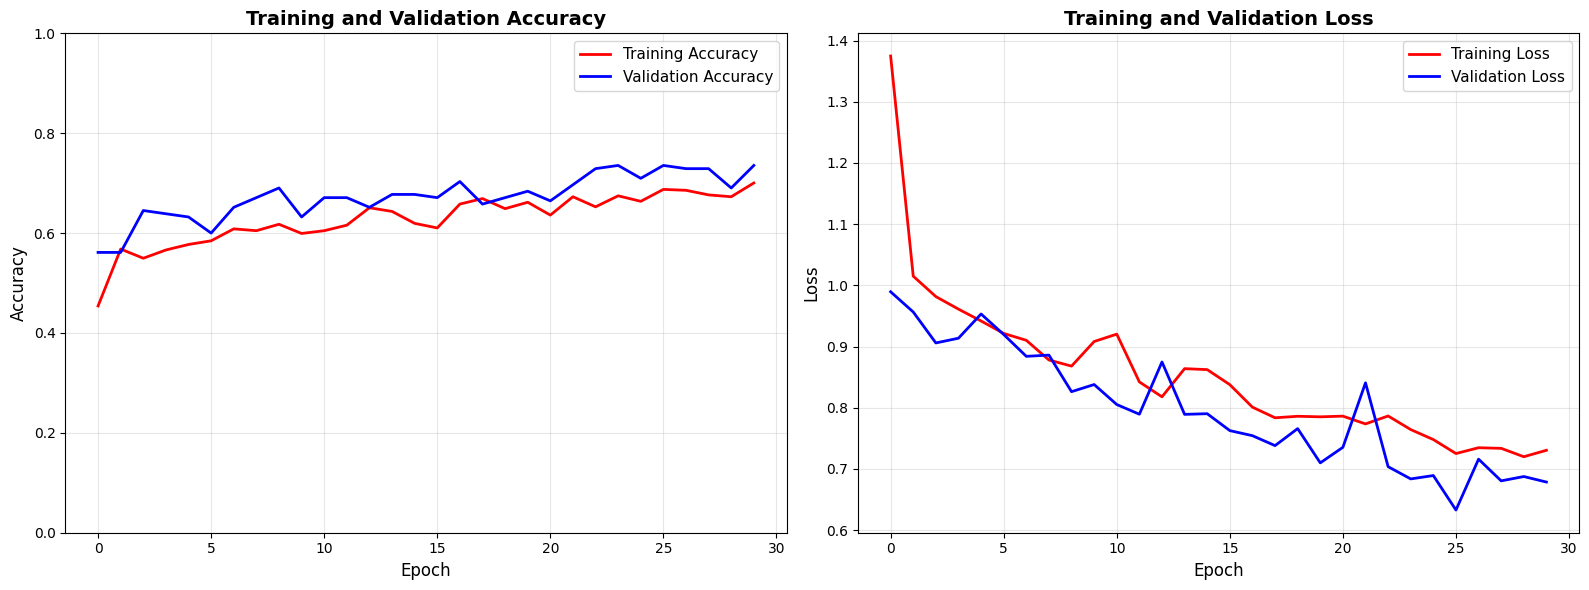


  Training Summary
  Best Training Accuracy:   0.7004 (epoch 30)
  Best Validation Accuracy: 0.7355 (epoch 24)
  Final Training Accuracy:  0.7004
  Final Validation Accuracy:0.7355
  Accuracy Gap (final):     0.0351


In [113]:
# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy
ax1.plot(epochs_range, acc, 'r-', linewidth=2, label="Training Accuracy")
ax1.plot(epochs_range, val_acc, 'b-', linewidth=2, label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Loss
ax2.plot(epochs_range, loss, 'r-', linewidth=2, label="Training Loss")
ax2.plot(epochs_range, val_loss, 'b-', linewidth=2, label="Validation Loss")
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"  Training Summary")
print(f"{'='*60}")
print(f"  Best Training Accuracy:   {max(acc):.4f} (epoch {acc.index(max(acc))+1})")
print(f"  Best Validation Accuracy: {max(val_acc):.4f} (epoch {val_acc.index(max(val_acc))+1})")
print(f"  Final Training Accuracy:  {acc[-1]:.4f}")
print(f"  Final Validation Accuracy:{val_acc[-1]:.4f}")
print(f"  Accuracy Gap (final):     {abs(acc[-1] - val_acc[-1]):.4f}")
print(f"{'='*60}")

## Evaluate model

In [114]:
# Evaluate on test set
preds = cnn_model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.6914 - loss: 0.6763
Loss = 0.6763023734092712
Test Accuracy = 0.6913580298423767


In [118]:
validation_generator.shuffle = False
y_true = validation_generator.classes
y_pred_probs = cnn_model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
              precision    recall  f1-score   support

      benign       0.72      0.95      0.82        87
   malignant       0.82      0.67      0.74        42
      normal       0.60      0.12      0.19        26

    accuracy                           0.74       155
   macro avg       0.71      0.58      0.58       155
weighted avg       0.73      0.74      0.69       155



In [119]:
test_generator.shuffle = False
y_true = test_generator.classes
y_pred_probs = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
              precision    recall  f1-score   support

      benign       0.50      0.68      0.58        44
   malignant       0.06      0.05      0.05        22
      normal       0.33      0.07      0.11        15

    accuracy                           0.40        81
   macro avg       0.30      0.26      0.25        81
weighted avg       0.35      0.40      0.35        81



In [120]:
train_generator.shuffle = False
y_true = train_generator.classes
y_pred_probs = cnn_model.predict(train_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 366ms/step
              precision    recall  f1-score   support

      benign       0.56      0.65      0.60       306
   malignant       0.27      0.27      0.27       146
      normal       0.11      0.04      0.06        92

    accuracy                           0.45       544
   macro avg       0.31      0.32      0.31       544
weighted avg       0.40      0.45      0.42       544



In [ ]:
train_preds = cnn_model.evaluate(train_generator)
test_preds = cnn_model.evaluate(test_generator)
val_preds = cnn_model.evaluate(validation_generator)

In [ ]:
print(f"  Best Training Accuracy:   {max(acc):.4f} (epoch {acc.index(max(acc))+1})")
print(f"  Best Validation Accuracy: {max(val_acc):.4f} (epoch {val_acc.index(max(val_acc))+1})")
print(f"  Final Training Accuracy:  {acc[-1]:.4f}")
print(f"  Final Validation Accuracy:{val_acc[-1]:.4f}")
print(f"  Accuracy Gap (final):     {abs(acc[-1] - val_acc[-1]):.4f}")

results = {"Training":
           {"Accuracy": acc[-1], "Recall": }
}